<a href="https://colab.research.google.com/github/sahil-bhatia-iitbhu/deep_understanding_of_deep_learning/blob/main/03_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Network

1. Perceptron
2. Forward propagation - weights, activation, linear and non-linear functions
3. Loss, Cost and Loss Function
4. Backpropagation

### Regression

Loss Function - Mean Squared Error (MSE)

In [ ]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

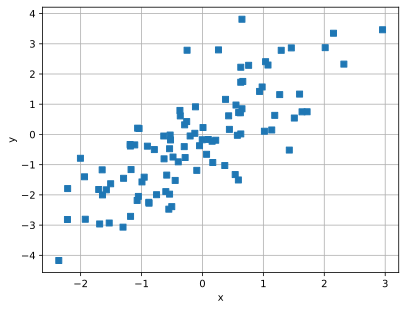

In [ ]:
# create data

N = 100
x = t.randn(N, 1)
y = x + t.randn(N, 1)

# plot the pairs
plt.plot(x, y, 's')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [ ]:
# build model

ANNreg = nn.Sequential(
    nn.Linear(1, 1, bias=True),  # input layer
    nn.ReLU(),                   # activation function
    nn.Linear(1, 1, bias=True)    # output layer
)

ANNreg

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
# learning rate
learningRate = 0.01

# loss function
lossfun = nn.MSELoss()

# optimizer (the flavour of gradient descent to be implemented)
optimizer = t.optim.SGD(ANNreg.parameters(), lr=learningRate)

In [ ]:
# train the model
numepoch = 1000
losses = t.zeros(numepoch)

for epochi in range(numepoch):

  # forward pass
  y_pred = ANNreg(x)

  # compute loss
  loss = lossfun(y_pred, y)
  losses[epochi] = loss

  # backpropagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

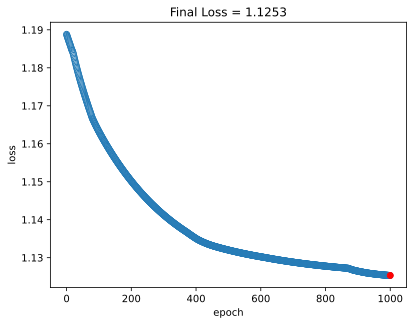

In [ ]:
# show the losses

# manually compute losses
# final forward pass
predictions = ANNreg(x)

# final loss (MSE)
testloss = (predictions - y).pow(2).mean()

plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=1)
plt.plot(numepoch, testloss.detach(), 'ro')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Final Loss = %g'%testloss.item())
plt.show()

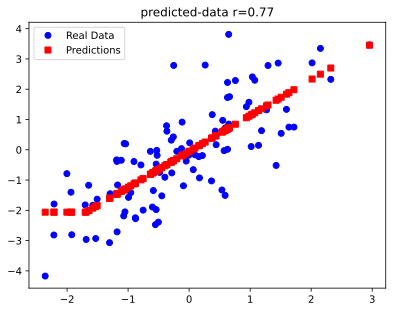

In [ ]:
# plot the data

plt.plot(x,y,'bo',label='Real Data')
plt.plot(x,predictions.detach(),'rs',label='Predictions')
plt.title(f"predicted-data r={np.corrcoef(y.T,predictions.detach().T)[0,1]:.2f}")
plt.legend()
plt.show()

### Manipulate Regression Slopes

In [ ]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [ ]:
def data(N,m):
  x = t.randn(N, 1)
  y = m*x + t.randn(N, 1) * 1.5
  return x, y

In [ ]:
def model(x,y,learning_rate,momentum,numepoch):

  # build model
  ANNreg = nn.Sequential(
      nn.Linear(1, 1, bias=True),  # input layer
      nn.ReLU(),                   # activation function
      nn.Linear(1, 1, bias=True)    # output layer
  )

  # loss function
  lossfun = nn.MSELoss()

  # learning rate and momentum
  lr = learning_rate
  mtm = momentum

  # optimizer (the flavour of gradient descent to be implemented)
  optimizer = t.optim.SGD(ANNreg.parameters(), lr=lr)

  # number of epochs
  nepoch = numepoch
  losses = t.zeros(nepoch)

  for i in range(nepoch):
    y_pred = ANNreg(x)
    loss = lossfun(y_pred, y)
    losses[i] = loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  predictions = ANNreg(x)

  return predictions, losses


In [ ]:
slopes = t.linspace(-2,2,21)
numExps = 50
results = np.zeros((len(slopes),numExps,2))

for i,m in enumerate(slopes):
  for j in range(numExps):
    x, y = data(50,slopes[i])
    yHat, losses = model(x,y,0.01,0.9,1000)

    # store the final loss and performance
    results[i,j,0] = losses[-1]
    results[i,j,1] = np.corrcoef(y.T,yHat.detach().T)[0,1]

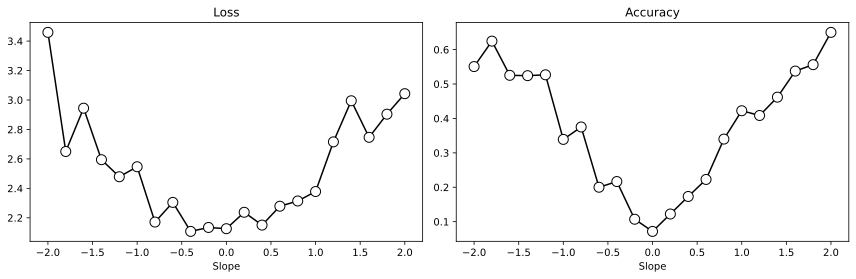

In [ ]:
# correlation can be 0 if the model didn't do well. Set nan's -> 0
results[np.isnan(results)] = 0

# plot loss and accuracy as a function of slope

fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(slopes,np.mean(results[:,:,0],axis=1), 'ko-', markerfacecolor='w', markersize=10)
ax[0].set_xlabel('Slope')
ax[0].set_title('Loss')

ax[1].plot(slopes,np.mean(results[:,:,1],axis=1), 'ko-', markerfacecolor='w', markersize=10)
ax[1].set_xlabel('Slope')
ax[1].set_title('Accuracy')

plt.tight_layout()
plt.show()

1. Why were losses larger with larger slopes, even though the fit to the data was better?
- Losses are not normalized, they are in the scale of data. Larger slopes led to more variance in y.

- **Note :** The losses could only be compared across same data, or in different dataset that are normalized to the same numeric range.

2. Why did the model accuracy dropped to 0 when the slope was close to 0?
- x is less informative about y when the slope descreases. The model had less useful information about y.

- **Note :** ANNs (and DL in general) don't predict data values; they learn relationships across variables and provide the distribution of y for a given x from which y_pred is chosen as the one y which holds highest probability of occurence.

### Classification

In [29]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

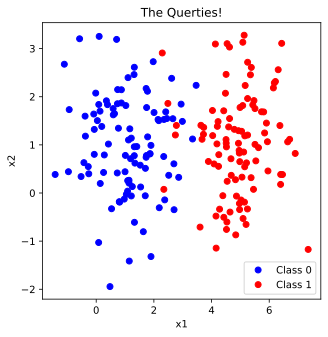

In [30]:
# catagorical dummy data

nPerClust = 100
blur = 1

A = [1,1]
B = [5,1]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to PyTorch
data = t.tensor(data_np).float()
labels = t.tensor(labels_np).float()

# plot the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('The Querties!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [31]:
# build the model
ANNclassify = nn.Sequential(
    nn.Linear(2, 1, bias=True),  # imput layer
    nn.ReLU(),                   # activation layer
    nn.Linear(1, 1, bias=True),  # output layer
    nn.Sigmoid(),                # final activation unit
)

ANNclassify

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)

In [32]:
# loss function
lossfun = nn.BCELoss()
# For future reference please note that it is better to use BCEWithLogitsLoss

# learning rate
lr = 0.1

# optimizer
optimizer = t.optim.SGD(ANNclassify.parameters(), lr=lr)

In [33]:
# number of epochs
numepochs = 1000
losses = t.zeros(numepochs)

for i in range(numepochs):

  # forward pass
  y_pred = ANNclassify(data)

  # calculate loss and store value
  loss = lossfun(y_pred,labels)
  losses[i] = loss

  # backpropagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

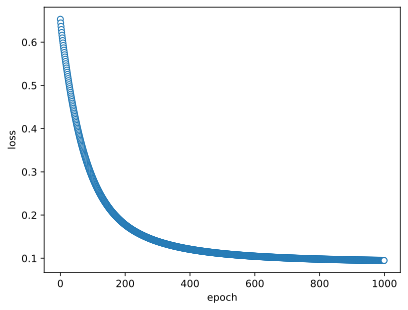

In [34]:
# show the losses

plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [35]:
# final forward pass
predictions = ANNclassify(data)

predlabels = predictions > 0.5

# find errors
misclassified = np.where(predlabels.detach().T != labels.T)[0]
# misclassified

# total accuracy
totalacc = 100 - 100*len(misclassified)/len(labels)

print(f'Total Accuracy = {totalacc}%')

Total Accuracy = 96.5%


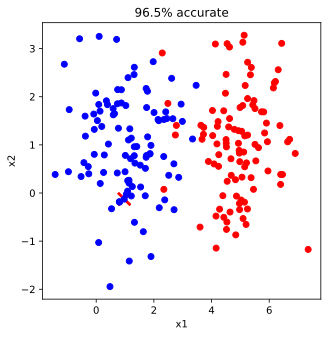

In [37]:
# plot the labeled data
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0], data[misclassified,1], 'rx' , markersize=12, markeredgewidth=2, label='Misclassified')
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title(f'{totalacc}% accurate')
plt.xlabel('x1')
plt.ylabel('x2')
# plt.legend()
plt.show()

### Learning Rate Comparison

In [38]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

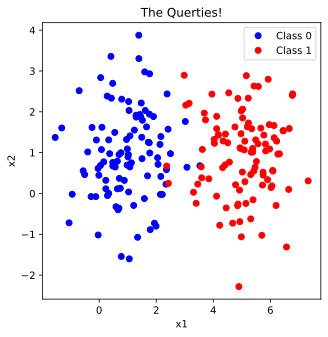

In [40]:
# catagorical dummy data

nPerClust = 100
blur = 1

A = [1,1]
B = [5,1]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to PyTorch
data = t.tensor(data_np).float()
labels = t.tensor(labels_np).float()

# plot the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('The Querties!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [41]:
def ANNclassify(learning_rate):
  # build the model
  ANNclassify = nn.Sequential(
      nn.Linear(2, 1, bias=True),  # imput layer
      nn.ReLU(),                   # activation layer
      nn.Linear(1, 1, bias=True),  # output layer
      # nn.Sigmoid(),                # final activation unit
  )

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = t.optim.SGD(ANNclassify.parameters(), lr=learning_rate)

  return ANNclassify, lossfun, optimizer

In [42]:
def train_model():
  # number of epochs
  numepochs = 1000
  losses = t.zeros(numepochs)

  for i in range(numepochs):

    # forward pass
    y_pred = ANNclassify(data)

    # calculate loss and store value
    loss = lossfun(y_pred,labels)
    losses[i] = loss

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # final predictions
  predictions = ANNclassify(data)

  # accuracy
  totalacc = 100*t.mean(((predictions > 0) == labels).float())

  return losses, predictions, totalacc